In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [2]:
def carregar_dados():

    df_ratings = pd.read_csv('ratings.csv')
    df_movies = pd.read_csv('movies.csv')
    df_tags = pd.read_csv('tags.csv')
    return df_ratings, df_movies, df_tags

In [3]:
def criar_matriz_caracteristicas(df_movies, df_tags):

    generos = df_movies['genres'].str.get_dummies('|').add_prefix('genre_')
    tags = df_tags.pivot_table(index='movieId', columns='tag', aggfunc='size', fill_value=0).add_prefix('tag_')

    matriz_caracteristicas = generos.join(tags, how='left').fillna(0)
    matriz_caracteristicas.index = df_movies['movieId']
    return matriz_caracteristicas

In [4]:
def recomendacao_conteudo_balanceada(matriz_caracteristicas, avaliacoes_usuario, df_movies, peso_similaridade=0.8):

    similaridade = cosine_similarity(matriz_caracteristicas)

    pca = PCA(n_components=2)
    vetores_reduzidos = pca.fit_transform(matriz_caracteristicas)

    vetores_reduzidos_norm = (vetores_reduzidos - vetores_reduzidos.min(axis=0)) / (
        vetores_reduzidos.max(axis=0) - vetores_reduzidos.min(axis=0)
    )

    escolhidos_idx = [
        matriz_caracteristicas.index.get_loc(filme_id)
        for filme_id, _ in avaliacoes_usuario
    ]
    pesos = [nota - 3 for _, nota in avaliacoes_usuario]

    recomendacoes = []
    for idx_film, peso in zip(escolhidos_idx, pesos):
        similaridade_filmes = similaridade[idx_film] * peso

        similaridade_filmes[idx_film] = -1

        distancias = np.linalg.norm(
            vetores_reduzidos_norm - vetores_reduzidos_norm[idx_film], axis=1
        )
        score_combined = (
            peso_similaridade * similaridade_filmes - (1 - peso_similaridade) * distancias
        )

        filmes_similares_idx = np.argsort(score_combined)[::-1][:3]
        filmes_similares = matriz_caracteristicas.index[filmes_similares_idx]
        recomendacoes.extend(filmes_similares)

    recomendacoes_unicas = list(dict.fromkeys(recomendacoes))

    return recomendacoes_unicas[:5]


In [5]:
def gerar_grafico(avaliacoes_usuario, recomendacoes, matriz_caracteristicas, df_movies):

    pca = PCA(n_components=2)
    vetores_reduzidos = pca.fit_transform(matriz_caracteristicas)

    plt.figure(figsize=(10, 6))
    plt.scatter(vetores_reduzidos[:, 0], vetores_reduzidos[:, 1], alpha=0.3, label='Outros Filmes', color='gray')

    for filme_id, _ in avaliacoes_usuario:
        idx = matriz_caracteristicas.index.get_loc(filme_id)
        plt.scatter(vetores_reduzidos[idx, 0], vetores_reduzidos[idx, 1], label=f'Escolhido: {df_movies[df_movies["movieId"] == filme_id]["title"].values[0]}', color='blue')
        plt.text(vetores_reduzidos[idx, 0], vetores_reduzidos[idx, 1], df_movies[df_movies["movieId"] == filme_id]["title"].values[0], fontsize=9)

    for filme_id in recomendacoes:
        idx = matriz_caracteristicas.index.get_loc(filme_id)
        plt.scatter(vetores_reduzidos[idx, 0], vetores_reduzidos[idx, 1], label=f'Recomendado: {df_movies[df_movies["movieId"] == filme_id]["title"].values[0]}', color='red')
        plt.text(vetores_reduzidos[idx, 0], vetores_reduzidos[idx, 1], df_movies[df_movies["movieId"] == filme_id]["title"].values[0], fontsize=9)

    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.title('Representação Gráfica dos Filmes')
    plt.legend()
    plt.show()



Digite até 5 filmes e sua avaliação sobre eles(1 - nao gostou do filme ... 5 - gostou muito do filme). Digite 'sair' para parar.
Filme (ID): 157340
Nota (1, 2, 3, 4, 5): 5
Filme (ID): 1
Nota (1, 2, 3, 4, 5): 5
Filme (ID): 146656
Nota (1, 2, 3, 4, 5): 5
Filme (ID): sair

Filmes recomendados e seus vetores:
Filme ID 3429 (Creature Comforts (1989)):
[0. 0. 0. ... 0. 0. 0.]
Filme ID 158872 (Sausage Party (2016)):
[0. 0. 0. ... 0. 0. 0.]
Filme ID 135436 (The Secret Life of Pets (2016)):
[0. 0. 0. ... 0. 0. 0.]
Filme ID 3754 (Adventures of Rocky and Bullwinkle, The (2000)):
[0. 0. 1. ... 0. 0. 0.]
Filme ID 103755 (Turbo (2013)):
[0. 0. 1. ... 0. 0. 0.]


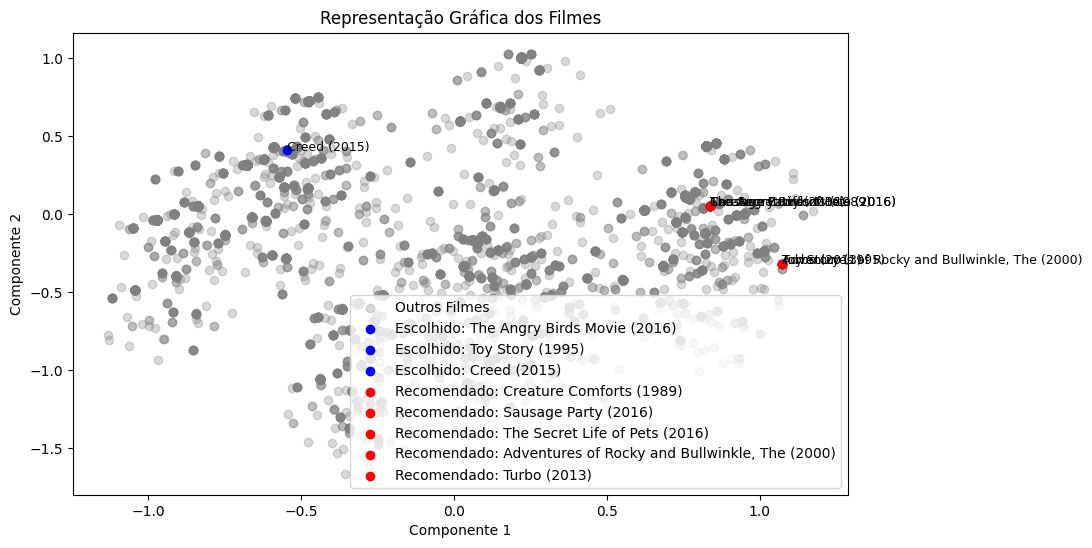

In [12]:
df_ratings, df_movies, df_tags = carregar_dados()

matriz_caracteristicas = criar_matriz_caracteristicas(df_movies, df_tags)

avaliacoes_usuario = []
print("Digite até 5 filmes e sua avaliação sobre eles(1 - nao gostou do filme ... 5 - gostou muito do filme). Digite 'sair' para parar.")

for _ in range(5):
  filme_input = input("Filme (ID): ")

  if filme_input.lower() == 'sair':
    break

  try:
    filme = int(filme_input)
    nota = int(input("Nota (1, 2, 3, 4, 5): "))

    if nota not in [1, 2, 3, 4, 5]:
      print("Por favor, insira apenas as notas entre 1 e 5.")
      continue

    avaliacoes_usuario.append((filme, nota))

  except ValueError:
    print("Entrada inválida. Por favor, digite um ID de filme numérico ou 'sair'.")
    continue


recomendacoes = recomendacao_conteudo_balanceada(matriz_caracteristicas, avaliacoes_usuario, df_movies)

print("\nFilmes recomendados e seus vetores:")

for filme_id in recomendacoes:
  print(f"Filme ID {filme_id} ({df_movies[df_movies['movieId'] == filme_id]['title'].values[0]}):")
  print(matriz_caracteristicas.loc[filme_id].values)

gerar_grafico(avaliacoes_usuario, recomendacoes, matriz_caracteristicas, df_movies)